In [4]:
#1

! pip install tensorboard

# Lenet-5 for fashion mnist

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os

# fasion-MNIST dataset

the fasion-MNIST dataset is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends fasion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

## loading the dataset
The dataset can be used from `torchvision.datasets` package. The dataset is downloaded from the internet and saved in the `data` directory. The dataset is loaded using the `torch.utils.data.DataLoader` class. The `DataLoader` class is used to load the data in batches. The `DataLoader` class takes the dataset and the batch size as input and provides an iterator to iterate over the dataset in batches.


## Transforms
### resize:
 The images in the fasion-MNIST dataset are of size 28x28. So, it makes sense to use the `transforms.Resize` to convert the images to a size that is compatible with the LeNet-5 architecture's input. The LeNet-5 architecture expects images of size 32x32 as input.
the original size of the images in the MNIST dataset is 28x28.

### ToTensor:
The `transforms.ToTensor` converts the images to PyTorch tensors. The images in the fasion-MNIST dataset are of type `PIL.Image.Image`. The `transforms.ToTensor` converts the images to PyTorch tensors of shape `(C, H, W)` where `C` is the number of channels, `H` is the height of the image, and `W` is the width of the image. The images in the fasion-MNIST dataset are grayscale images, so the number of channels is 1. The shape of the images after applying the `transforms.ToTensor` is `(1, 32, 32)`.


In [11]:
fashion_mnist_train = datasets.FashionMNIST('data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
]))

## Test dataset

In [12]:
fashion_mnist_test = datasets.FashionMNIST('data', train=False, download=True, transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
]))

### split the dataset to test and validation

In [13]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Split fashion_mnist_train into train and val sets
train_indices, val_indices = train_test_split(list(range(len(fashion_mnist_train))), test_size=0.2, random_state=42)

train_subset = Subset(fashion_mnist_train, train_indices)
val_subset = Subset(fashion_mnist_train, val_indices)

# DataLoaders
batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)


## Tensorboard

tensorboard is a visualization tool that can be used to visualize the training process of a deep learning model. The `torch.utils.tensorboard.SummaryWriter` class is used to write the logs to the tensorboard. The `SummaryWriter` class takes the log directory as input. The logs are written to the log directory in the form of event files. The event files can be visualized using the tensorboard web interface.



In [14]:
#%tensorboard --logdir runs
log_dir = os.path.join(os.getcwd(), "runs")
os.makedirs(log_dir, exist_ok=True)


UsageError: Line magic function `%tensorboard` not found.


## Visualize the dataset
let's draw 5 random images from the dataset and visualize them. The images are grayscale images of size 32x32. The images are converted to PyTorch tensors of shape `(1, 32, 32)` using the `transforms.ToTensor` transform. The images are then visualized using the `matplotlib.pyplot.imshow` function. we can also decode the labels to see how the images are labeled.

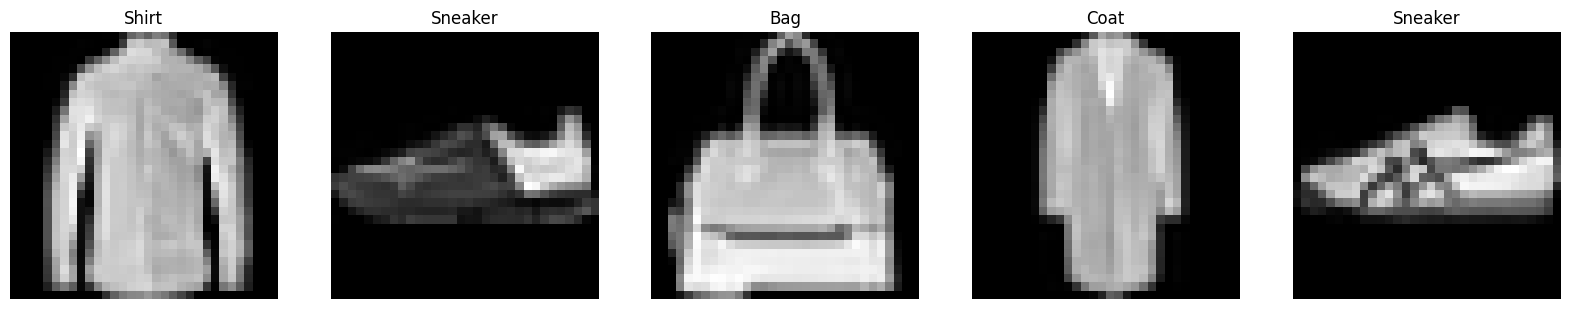

In [15]:
# get 5 images
imgs = [0]*5
labels = [0]*5
for idx, i in enumerate(np.random.randint(0, len(fashion_mnist_train), 5)):
    imgs[idx], labels[idx] = fashion_mnist_train[i]

#visualize the 5 image
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(imgs[i].permute(1, 2, 0), cmap='gray')
    ax[i].set_title(fashion_mnist_train.classes[labels[i]])
    ax[i].axis('off')
    #decode the label
    label = fashion_mnist_train.classes[labels[i]]


markdown bold text -

# LeNet-5 Architecture
The LeNet-5 architecture is a convolutional neural network architecture proposed by Yann LeCun in 1998. The LeNet-5 architecture consists of 7 layers. The architecture of the LeNet-5 is as follows:

#### **input layer:**
The input to the LeNet-5 architecture is a grayscale image of size 32x32.

#### Convolution & Average Pooling Layers:
next, the input image is passed through a convolutional layer followed by an average pooling layer.
The convolutional layer has 6 filters of size 5x5.
- **kernel size:** 5x5
-  **channels:** $1 \rightarrow 6$
- **stride:** 1
The average pooling layer has a filter of size 2x2.
- **kernel size:** 2x2
- **stride:** 2

#### 2nd Convolution & Average Pooling Layers:
The output from the first average pooling layer is passed through another convolutional layer followed by another average pooling layer.
The convolutional layer has 16 filters of size 5x5.
- **kernel size:** 5x5
- **channels:** $6 \rightarrow 16$
- **stride:** 1
average pooling layer has a filter of size 2x2.
- **kernel size:** 2x2
- **stride:** 2

#### convolutional layer:
The output from the second average pooling layer is passed through another convolutional layer.
- **kernel size:** 5x5
- **output channels:** 120
- **stride:** 1

#### Fully Connected Layers:
The output from the last convolutional layer is flattened and passed through 3 fully connected layers:
- **1st fully connected layer:** $120 \rightarrow 84$
- **2nd fully connected layer:** $84 \rightarrow 10$
#### Output Layer:
The output from the last fully connected layer is passed through a softmax activation function to get the best of 10 class probabilities.



In [16]:
class Lenet5(nn.Module):
    def __init__(self, dropout_prob=0, batch_norm=False):
        super(Lenet5, self).__init__()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()
        self.batch_norm3 = nn.BatchNorm2d(120) if batch_norm else nn.Identity()
        self.batch_norm_fc1 = nn.BatchNorm1d(84) if batch_norm else nn.Identity()
        self.dropout_prob = dropout_prob
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            self.batch_norm1,
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            self.batch_norm2,
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh(),
            self.batch_norm3,
        )

        # fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            self.batch_norm_fc1,)

        self.fc2 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        self.dropout
        x = self.conv3(x)
        self.dropout
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.softmax(x)
        return x


let's initialize the model and print the model summary.then let's try it on a single batch of images to see if the model is working correctly.

In [17]:
model = Lenet5()
print(model)

pred = model(fashion_mnist_train[0][0].unsqueeze(0))
print (pred)

Lenet5(
  (batch_norm1): Identity()
  (batch_norm2): Identity()
  (batch_norm3): Identity()
  (batch_norm_fc1): Identity()
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Tanh()
    (4): Identity()
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Tanh()
    (4): Identity()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): Identity()
  )
  (fc1): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Identity()
  )
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
tensor([[-0.0292,  0.0873, -0.0046, -0.0910, -0.0258, -0.0462, -0.1092, -0.0230,
          0.1359, -0.1107]], grad_fn=<AddmmBackward0>)


## visualizing the model

In [18]:
tb_writer = SummaryWriter('runs/lenet5')

# visualize the model in our tensorboard summary
tb_writer.add_graph(model, fashion_mnist_train[0][0].unsqueeze(0))
tb_writer.flush()



# Training the model

In [ ]:
# hyperparameters
batch_size = 256
dropout_prob = 0.3
weight_decay = 0.0001
batch_norm = False
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()


# training the model
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# training loop

In [ ]:
def evaluate(model, val_loader):
    """
    evaluate the model on the validation set
    :param model: model to evaluate
    :param val_loader: validation dataset loader
    :return: (accuracy, loss)
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = running_acc / total
        loss = running_loss/ len(val_loader)
    return accuracy, loss

In [ ]:



from datetime import datetime


def train(model = Lenet5,
          train_loader=train_loader,
          val_loader=val_loader,
          criterion = criterion,
          optimizer = optimizer,
          epochs=epochs,
          session = None,
          batch_norm = False,
          dropout = 0.2,
          ):

    # track with tensorboard
    session = session or 'Lenet5'+datetime.now().strftime('%m-%d-%H-%M')
    #tb_writer = SummaryWriter(f'runs/{session}')
    run_dir = f'{log_dir}/{session}'
    print(run_dir)
    tb_writer = SummaryWriter(run_dir)
    tb_writer.flush()

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        train_total = 0
        val_loss_min = 0
        # set the model to train mode
        model.train(True)

        for i, data in enumerate(train_loader, 0):

            # get the input image and labels
            inputs, labels = data

            # start with zero gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            loss.backward()
            # update the weights
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            running_corrects += (preds == labels).sum().item()
            train_total += labels.size(0)

            if i % 100 == 99:
                # print gradient statistics
                for name, param in model.named_parameters():
                    tb_writer.add_histogram(name, param.grad, epoch * len(train_loader) +  i)
                # loss of current batch
                avg_train_loss = running_loss / 100
                tb_writer.add_scalar('training loss', avg_train_loss, epoch * len(train_loader) +  i)

                #print(f'[{epoch + 1}, {i + 1}] loss: {avg_train_loss}')
                running_loss = 0.0
        """-----------------
        per epoch evaluation
        -----------------"""
        # set the model to evaluation mode
        model.eval()

        #accuracy
        train_accuracy = running_corrects / train_total
        # validation
        val_acc, val_loss = evaluate(model, val_loader)

        #val_accuracy = (val_preds == val_labels).sum().item() / len(val_loader)
        tb_writer.add_scalars('train vs val loss', {'train': avg_train_loss, 'val': val_loss}, epoch)
        tb_writer.add_scalars('train vs val accuracy', {'train': train_accuracy, 'val': val_acc}, epoch)
        print(f'at epoch {epoch}: \nvalidation loss: {val_loss} \ntraining loss:   {avg_train_loss} ')
        tb_writer.add_scalar('validation loss', val_loss, epoch)
        if val_loss <= val_loss_min:
            print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), f'./models/Lenet_{session}.pth')
            valid_loss_min = valid_loss
    print('Finished Training')

# training the model without dropout, batch normalization or weight decay

In [ ]:
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()
model = Lenet5(dropout=0, batch_norm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session='vanilla lenet5')

# training the model with batch normalization


In [ ]:
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()
model = Lenet5(dropout=0, batch_norm=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session = 'with batch norm')

# training the model with weight decay

In [ ]:
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()
model = Lenet5(dropout=0, batch_norm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)


train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session = 'with weight decay')



In [ ]:
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()
model = Lenet5(dropout=False, batch_norm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)


train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session = 'with weight decay e-3')


In [ ]:
learning_rate= 1e-3
epochs = 100
criterion = nn.CrossEntropyLoss()
model = Lenet5(dropout=False, batch_norm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

model = Lenet5(dropout_prob=dropout_prob, batch_norm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session = 'with_dropout_final')

train(model = model,
      train_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      epochs = epochs,
      session = 'with weight decay e-2')

In [ ]:
# testing the model

imgs, labels = next(iter(test_loader))
outputs = model(imgs)
_, predicted = torch.max(outputs, 1)

# visualize the images
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(imgs[i].squeeze(), cmap='gray')
    ax[i].set_title(f'predicted: {fashion_mnist_train.classes[predicted[i]]}, actual: {fashion_mnist_train.classes[labels[i]]}')
    ax[i].axis('off')

# Hyperparameters
Let's investigate the results for different hyperparameters choices!
tensorboard allows us to compare the results of different hyperparameters choices. We can compare the results of different hyperparameters choices using the tensorboard web interface. We can compare the training and validation loss for different hyperparameters choices using the tensorboard web interface.

In [ ]:
# hyperparameters
dropout = [0.2, 0.3, 0.5]